Gender Prediction 

Authors: David Tang, Karmveer Sidhu, Waley Chen

This is an implementation of an SVM model to classify gender in our IMDb data set. We used several libraries but primarily employed sckimage and sklearn to process the images and create the SVM model. Our labels were in a matlab file so we put it into a dataframe before extracting our labels. Also all the images were not in the same order as the labels so we had to clean the full_paths before finding the image. Afterwards, we cropped the faces using face_location and put all the information into a numpy array. We fed this data into our SVM model to determine training and testing accuracy. We also created classification reports which include precision, recall, f1-score, and support values. Finally, we plotted this data in matplotlib. 

In [22]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from sklearn import svm, metrics
from skimage.transform import resize
import shutil
import os
from matplotlib import pyplot as plt
import math
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import os.path
from PIL import ImageFile
from time import sleep
import sys



ImageFile.LOAD_TRUNCATED_IMAGES = True

#Reads mat file and returns a dataframe with matlab IMDb data
def readmat(mat_file):
    data = loadmat(mat_file)
    mdata = data['imdb']
    mdtype = mdata.dtype
    names = [x[0] for x in mdtype.fields.items()]
    ndata = {n: mdata[n][0,0] for n in mdtype.names}
    columns = [n for n, v in ndata.items() if v.size == ndata['dob'].size]
    test = np.concatenate([ndata[c] for c in columns], axis=0)
    test = np.column_stack(test)
    df = pd.DataFrame(test, columns=columns)
    return df

#Crops and save images according to the face location in matfile. 
def face_crop(df):
    photo_wd = os.getcwd() + '/1000_Photos' #location of photos
    new_wd = os.getcwd() + '/Cropped_1000' #folder for new photos

    for index, row in df.iterrows():
        path = np.array2string(row['full_path']).strip("[]").strip('\'')[2:]
        img = imread(photo_wd + path)
        face_location = row['face_location'][0].astype(int)
        face_image = img[face_location[1]:face_location[3],face_location[0]:face_location[2]]
        imsave(new_wd + path, face_image)
               
#Zips photos in a folder
def zip_photos():
    zipfile_name = '' #name for zip file
    folder = os.getcwd() + '' #WD of files
    shutil.make_archive(zipfile_name, 'zip', folder)
    
#Unpacks an archive
def unpack(archive, extract_dir):
    try:
        shutil.unpack_archive(archive, extract_dir = extract_dir)
        print('Archive extracted')
    except FileNotFoundError:
        print('File or folder not found')
    
#Crops, resizes and appends images, gender to list
def prep_images(df, folder):
    imgs = []
    flat_data = []
    genders = []
    cwd = os.getcwd() + folder
    num_files = len([f for f in os.listdir(cwd) if os.path.isfile(os.path.join(cwd, f))])
    i = 0
    j = 0
    progress = 100/len(df.index)

    for index, row in df.iterrows():
        path = np.array2string(row['full_path']).strip("[]").strip('\'')[2:]
        img = imread(cwd+path, as_gray=True)
        face_location = row['face_location'][0].astype(int)
        face_image = img[face_location[1]:face_location[3],face_location[0]:face_location[2]]
        face_image = resize(face_image, (100,100), anti_aliasing=True, mode='reflect')
        flat_data.append(face_image.flatten())
        imgs.append(face_image)
        genders.append(row['gender'])
        
        if index % 100 == 0:
            print(index, ' completed')
        
        if index + 1 == num_files:
            break
            
    return flat_data, genders   
#         sys.stdout.write('\r')
#         # the exact output you're looking for:
#         sys.stdout.write("[%-20s] %d%%" % ('='*j, progress*i))
#         sys.stdout.flush()
#         sleep(0.25)
        
#         if i% (len(df.index)*0.05)==0 and i!= 0:
#             j+=1
            
#         i+=1

    #         if math.isnan(row['gender']):
    #             print('Image: ', index)
    #             print(row['full_path'])
    #             plt.figure()
    #             plt.imshow(face_image)
    #             plt.show()

        


def svm_clf(genders, flat_data):
    flat_data = np.array(flat_data)

    genders = np.array(genders)
    for i, gender in enumerate(genders):
        if math.isnan(gender):
            genders[i] = 1.0

    print('Males: ', list(genders).count(1.0))
    print('Females: ', list(genders).count(0))


    x_train, x_test, y_train, y_test = train_test_split(
        flat_data, genders, test_size=0.3,random_state=100)


    svc = svm.SVC(gamma=0.001, class_weight='balanced')
    clf = svc.fit(x_train, y_train)


    y_pred = clf.predict(x_test)


    print("Classification report for - \n{}:\n{}\n".format(
        clf, metrics.classification_report(y_test, y_pred)))

    test_acc = accuracy_score(y_test, y_pred)
    train_acc = clf.score(x_train, y_train)

    print('Testing Accuracy: ', test_acc)
    print('Training Accuracy: ', train_acc)
    
    return test_acc, train_acc 



In [2]:
mat_file = 'imdb.mat'
df = readmat(mat_file)

In [7]:
flat_data_1000, genders_1000 = prep_images(df[0:1000], '/1000_Photos')
test_acc_1000, train_acc_1000 = svm_clf(genders_1000, flat_data_1000)

Males:  721
Females:  279
Classification report for - 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.40      0.67      0.50        76
        1.0       0.86      0.67      0.75       224

avg / total       0.74      0.67      0.69       300


Testing Accuracy:  0.6666666666666666
Training Accuracy:  0.8128571428571428


In [15]:
flat_data_3000, genders_3000 = prep_images(df[0:3000], '/3000_Photos')
test_acc_3000, train_acc_3000 = svm_clf(genders_3000, flat_data_3000)

Males:  2182
Females:  818
Classification report for - 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.37      0.56      0.44       239
        1.0       0.80      0.65      0.72       661

avg / total       0.69      0.63      0.65       900


Testing Accuracy:  0.6255555555555555
Training Accuracy:  0.7661904761904762


In [24]:
flat_data_5000, genders_5000 = prep_images(df[0:5000], '/5000_Photos')
test_acc_5000, train_acc_5000 = svm_clf(genders_5000, flat_data_5000)

0  completed
100  completed
200  completed
300  completed
400  completed
500  completed
600  completed
700  completed
800  completed
900  completed
1000  completed
1100  completed


C:\Users\david\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (92583050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\david\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (92320489 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


1200  completed
1300  completed
1400  completed
1500  completed
1600  completed
1700  completed
1800  completed
1900  completed
2000  completed
2100  completed
2200  completed
2300  completed
2400  completed
2500  completed
2600  completed
2700  completed
2800  completed
2900  completed
3000  completed
3100  completed
3200  completed
3300  completed
3400  completed
3500  completed
3600  completed
3700  completed
3800  completed
3900  completed
4000  completed
4100  completed
4200  completed
4300  completed
4400  completed
4500  completed
4600  completed
4700  completed
4800  completed
4900  completed
Males:  3052
Females:  1948
Classification report for - 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.54      0.64      0.58       5

In [25]:
flat_data_7000, genders_7000 = prep_images(df[0:7000], '/7000_Photos')
test_acc_7000, train_acc_7000 = svm_clf(genders_7000, flat_data_7000)

0  completed
100  completed
200  completed
300  completed
400  completed
500  completed
600  completed
700  completed
800  completed
900  completed
1000  completed
1100  completed


C:\Users\david\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (92583050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\david\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (92320489 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


1200  completed
1300  completed
1400  completed
1500  completed
1600  completed
1700  completed
1800  completed
1900  completed
2000  completed
2100  completed
2200  completed
2300  completed
2400  completed
2500  completed
2600  completed
2700  completed
2800  completed
2900  completed
3000  completed
3100  completed
3200  completed
3300  completed
3400  completed
3500  completed
3600  completed
3700  completed
3800  completed
3900  completed
4000  completed
4100  completed
4200  completed
4300  completed
4400  completed
4500  completed
4600  completed
4700  completed
4800  completed
4900  completed
5000  completed
5100  completed
5200  completed
5300  completed
5400  completed
5500  completed
5600  completed
5700  completed
5800  completed
5900  completed
6000  completed
6100  completed
6200  completed
6300  completed
6400  completed
6500  completed
6600  completed
6700  completed
6800  completed
6900  completed
Males:  4005
Females:  2995
Classification report for - 
SVC(C=1.0, cach

In [26]:
flat_data_10k, genders_10k = prep_images(df[0:10000], '/10K_Photos')
test_acc_10k, train_acc_10k = svm_clf(genders_10k, flat_data_10k)

0  completed
100  completed
200  completed
300  completed
400  completed
500  completed
600  completed
700  completed
800  completed
900  completed
1000  completed
1100  completed


C:\Users\david\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (92583050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\david\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (92320489 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


1200  completed
1300  completed
1400  completed
1500  completed
1600  completed
1700  completed
1800  completed
1900  completed
2000  completed
2100  completed
2200  completed
2300  completed
2400  completed
2500  completed
2600  completed
2700  completed
2800  completed
2900  completed
3000  completed
3100  completed
3200  completed
3300  completed
3400  completed
3500  completed
3600  completed
3700  completed
3800  completed
3900  completed
4000  completed
4100  completed
4200  completed
4300  completed
4400  completed
4500  completed
4600  completed
4700  completed
4800  completed
4900  completed
5000  completed
5100  completed
5200  completed
5300  completed
5400  completed
5500  completed
5600  completed
5700  completed
5800  completed
5900  completed
6000  completed
6100  completed
6200  completed
6300  completed
6400  completed
6500  completed
6600  completed
6700  completed
6800  completed
6900  completed
7000  completed
7100  completed
7200  completed
7300  completed
7400  co

In [35]:
test_acc = [test_acc_1000, test_acc_3000, test_acc_5000, test_acc_7000, test_acc_10k]
train_acc = [train_acc_1000, train_acc_3000, train_acc_5000, train_acc_7000, train_acc_10k]
photos = [1000, 3000, 5000, 7000, 10000]

results = list(zip(photos, test_acc, train_acc))
header = ['Photos', 'Test Accuracy', 'Train Accuracy']

print(results)

[(1000, 0.6666666666666666, 0.8128571428571428), (3000, 0.6255555555555555, 0.7661904761904762), (5000, 0.642, 0.7522857142857143), (7000, 0.6523809523809524, 0.7440816326530613), (10000, 0.6523333333333333, 0.7455714285714286)]


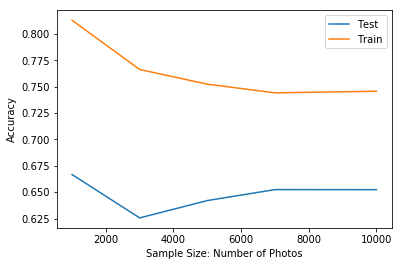

In [39]:
# multiple line plot
plt.plot(photos, test_acc, label='Test')
plt.plot(photos, train_acc, label='Train')
plt.xlabel('Sample Size: Number of Photos')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')
plt.show()


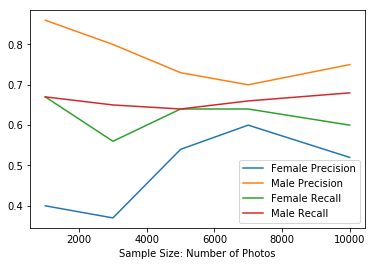

In [40]:
f_precision = [0.4,0.37,0.54,0.60,0.52]
m_precision = [0.86,0.80,0.73,0.70,0.75]
f_recall = [0.67,0.56,0.64,0.64,0.60]
m_recall = [0.67,0.65,0.64,0.66,0.68]

plt.plot(photos, f_precision, label='Female Precision')
plt.plot(photos, m_precision, label='Male Precision')
plt.plot(photos, f_recall, label='Female Recall')
plt.plot(photos, m_recall, label='Male Recall')
plt.xlabel('Sample Size: Number of Photos')
plt.legend()
plt.savefig('precision_recall.png')
plt.show()